In [1]:
from transformer_BigBirdA2C import *
from dataset import make_data_generator
import json
from tqdm import tqdm_notebook as tqdm
#from torchsummary import summary

In [2]:
folder = 'data/BBC/'
data_name = folder+'data.json'
# validation_name = folder+'valid_seq.json'
# testdata_name = folder+'testdata_seq.json'
vocab_name = folder+'vocab.json'

In [3]:
num_epochs = 1000
save_rate = 1 #how many epochs per modelsave
#continue_from = "trained/Model1" # if none, put None
continue_from = None
epsilon = 1e-8
validation_size = 10000
device = torch.device('cuda')
!mkdir -p trained

In [4]:
vocab = json.load(open(vocab_name, 'r'))
VOC_SIZE = len(vocab)
INPUT_MAX = 100
SUMM_MAX = 20
UNK = "[UNK]"
BOS = "[CLS]"
EOS = "[SEP]"
PAD = "[PAD]"

In [5]:
batch_size = 16

training_set, training_generator = make_data_generator(\
data_name, INPUT_MAX, SUMM_MAX, vocab[PAD], batch_size, cutoff=None, shuffle=True, num_workers=4)

# validation_set, validation_generator = make_data_generator(\
# validation_name, INPUT_MAX, OUTPUT_MAX, vocab[PAD], batch_size, cutoff=validation_size, shuffle=False, num_workers=4)

def data_gen_train():
    for src, label, tgt in training_generator:
        src = src.to(device)
        label = (label).long().to(device)
        tgt = tgt.to(device)
        b = Batch(src, tgt, vocab[PAD])
        b.label = label
        yield b

loading json
load json done.


In [6]:
import math
total_train = int(math.ceil(training_set.size / batch_size))
# total_valid = int(math.ceil(validation_set.size / batch_size))
# print(total_train, total_valid)

In [7]:
def make_translator(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, emb_share=False):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    src_emb = nn.Sequential(Embeddings(d_model, src_vocab), c(position))
    tgt_emb = src_emb if emb_share else nn.Sequential(Embeddings(d_model, tgt_vocab), c(position))
    
    model = Translator(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        src_emb,
        tgt_emb,
        Generator(d_model, tgt_vocab))
    
    return model

In [8]:
def make_classifier(src_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    bert = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        vocab[PAD]
    )
    
    model = Classifier(
        bert
        # criterion = CE
    )

    return model

In [9]:
def make_discriminator(src_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    bert = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        vocab[PAD]
    )
    
    model = Discriminator(
        bert
    )
    
    return model

In [10]:
def init_param(model):
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)

def make_big_bird(vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1, emb_share=False, bert_share=False):
    "Helper: Construct a model from hyperparameters."
    
    vocab_sz = len(vocab)
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    
    src_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    if emb_share:        
        tgt_emb = src_emb
        bert_class_emb = src_emb
        bert_discr_emb = src_emb
    else:
        tgt_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_class_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
        bert_discr_emb = nn.Sequential(Embeddings(d_model, vocab_sz), c(position))
    
    
    bert_class = BERT(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        bert_class_emb,
        vocab[PAD]
    )
    
    if bert_share:
        bert_discr = bert_class
    else:
        bert_discr = BERT(
            Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
            bert_discr_emb,
            vocab[PAD]
        )
    
    translator = Translator(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        src_emb,
        tgt_emb,
        Generator(d_model, vocab_sz),
        CriticNet(d_model)
        )
    
    classifier = Classifier(
        bert_class
        # criterion = BCE
    )
        
    discriminator = Discriminator(
        bert_discr
    )
        
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for m in [translator, classifier, discriminator]:
        init_param(m)
            
    # creation of big bird
    model = BigBird(
        translator, discriminator, classifier, 
        vocab, gamma=0.99, clip_value=0.1, #for WGAN, if WGAN-GP is used this is useless 
        lr_G = 0.0,
        lr_D = 0.0,
        lr_C = 2e-5,
        LAMBDA = 10, # Gradient penalty lambda hyperparameter
        RL_scale = 1,
        device = device
    )

    return model


In [11]:
model = make_big_bird(vocab, N=4, d_model=256, d_ff=512, h=8, dropout=0.1, emb_share=True, bert_share=True)
model.load("Nest/NewbornBirdA2C")

load Bird from Nest/NewbornBirdA2C


In [12]:
vocab_inv = {a:b for b, a in vocab.items()}
def convert_ids_to_tokens(ids):
    return [vocab_inv[i] for i in ids]

In [ ]:
start = 1 if continue_from == None else (int(continue_from.split("Model")[-1])+1)
history = []
for epoch in range(start, num_epochs+1):
    print("Epoch", epoch)
    
    # training
    stats = Stats()
    model.train()
    trange = tqdm(enumerate(data_gen_train()), total=total_train)
    for i, batch in trange:
        loss, score  = model.run_iter(batch.src, batch.src_mask, SUMM_MAX, batch.trg, batch.label, D_iters=1, verbose = 0)
        trange.set_postfix(
            **{'RL_loss': '{:.3f}'.format(loss[0])},
            **{'G_loss': '{:.3f}'.format(loss[1])},
            **{'D_loss': '{:.3f}'.format(loss[2])},
            **{'real_score': '{:.3f}'.format(score[0])},
            **{'fake_score': '{:.3f}'.format(score[1])},
            **{'acc': '{:.3f}'.format(score[2])},
            **{'reward':'{:.3f}'.format(score[3])}
        )
        stats.update(score[3], 1, log=0)
        
    t_h = stats.history
    history.append(t_h)
    
    print("[info] epoch train loss:", np.mean(t_h))
    
#     try:
#         torch.save({'model':model.state_dict(), 'training_history':t_h, 'validation_loss':np.mean(v_h)}, 
#                    "trained/Model"+str(epoch))
#     except:
#         continue

Epoch 1



[info] epoch train loss: -2.215169481720243
Epoch 2



[info] epoch train loss: -2.216870445013046
Epoch 3


In [14]:
import matplotlib.pyplot as plt

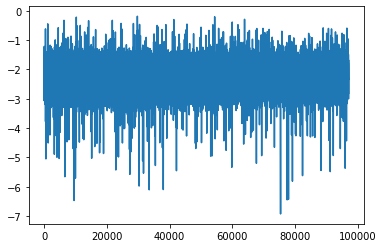

In [20]:
#print(model.all_rewards)
plt.plot(range(len(model.all_rewards)), model.all_rewards)

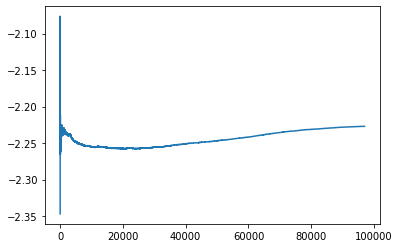

In [24]:
plt.plot(range(len(model.all_rewards)-1), [sum(model.all_rewards[:i])/i for i in range(1,len(model.all_rewards))])